# LLM-Powered Traffic Analysis and Reporting

This notebook demonstrates an end-to-end process for analyzing traffic data, predicting braking events using a machine learning model (XGBoost), and then integrating a Large Language Model (LLM) to generate detailed traffic analysis reports based on the model's insights and raw data. Finally, it sets up a simple Streamlit application to interact with the LLM for report generation.

## Table of Contents
1.  **Environment Setup and Library Imports**
2.  **Data Loading and Initial Exploration**
3.  **Data Preprocessing and XGBoost Model Training**
4.  **Model Evaluation and Visualization**
5.  **Feature Importance and Model Saving**
6.  **LLM Integration: Embeddings, Vector Store, and Report Generation**
7.  **Streamlit Application for Interactive Reporting**

---

### 1. Environment Setup and Library Imports

This section handles the installation of necessary libraries and imports all modules required for the subsequent steps, including data manipulation, machine learning, and LLM operations. It ensures that all dependencies are met before proceeding with the data analysis and model building.

In [ ]:
!pip install -r requirements.txt

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from dotenv import load_dotenv
import os
from openai import OpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
import pandas as pd
import joblib
# from google.colab import userdata
from huggingface_hub import login

In [ ]:
!pip install -U langchain-community
!pip install faiss-cp

### 2. Data Loading and Initial Exploration

This cell loads the `combined_traffic_data.csv` file into a Pandas DataFrame. The `.head()` method is used to display the first few rows of the dataset, providing an initial overview of its structure, columns, and data types. This step is crucial for understanding the raw data we'll be working with.

In [5]:
combined_data = pd.read_csv('combined_traffic_data.csv')
combined_data.head()

,Time,VehicleID,MsgCount,TemporaryID,Latitude,Longitude,Elevation,PositionalAccuracy,Speed,Heading,TransmissionState,BrakeStatus,VehicleLength,VehicleWidth,IntersectionID,SignalGroup,State,TimeRemaining
0,2.0,1,0,36515,39.162939,-84.5197,300,1.5,13.89,180,2,0,4.5,1.8,1,NS,1,38.0
1,2.5,1,0,36515,39.162877,-84.5197,300,1.5,13.89,180,2,0,4.5,1.8,1,NS,1,37.5
2,3.0,1,0,36515,39.162814,-84.5197,300,1.5,13.89,180,2,0,4.5,1.8,1,NS,1,37.0
3,3.5,1,0,36515,39.162752,-84.5197,300,1.5,13.89,180,2,0,4.5,1.8,1,NS,1,36.5
4,4.0,1,0,36515,39.162689,-84.5197,300,1.5,13.89,180,2,0,4.5,1.8,1,NS,1,36.0


### 3. Data Preprocessing and XGBoost Model Training

In this section, the data is preprocessed, and an XGBoost Classifier model is trained.
- The 'State' column, which likely contains categorical data, is converted into numerical format using `LabelEncoder`.
- Relevant features (`Speed`, `Heading`, `TimeRemaining`, `State`, `PositionalAccuracy`) are selected for training.
- The data is split into training and testing sets to evaluate the model's performance on unseen data.
- An XGBoost Classifier is initialized and trained on the training data to predict `BrakeStatus`.
- Finally, predictions are made on the test set.

In [7]:
# Create a LabelEncoder object
le = LabelEncoder()
combined_data['State'] = le.fit_transform(combined_data['State'])

# Select relevant features and target
features = ['Speed', 'Heading', 'TimeRemaining', 'State', 'PositionalAccuracy']
X = combined_data[features]
y = combined_data['BrakeStatus']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Classifier
model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

### 4. Model Evaluation and Visualization

This cell evaluates the trained XGBoost model's performance using a Confusion Matrix and a Classification Report.
- A heatmap of the confusion matrix is generated using `seaborn` to visually represent the true positive, true negative, false positive, and false negative predictions. This helps in understanding where the model is performing well and where it makes errors.
- The `classification_report` provides key metrics such as precision, recall, and F1-score for each class ('No Brake' and 'Brake'), along with overall accuracy. These metrics are crucial for a comprehensive assessment of the model's predictive power.

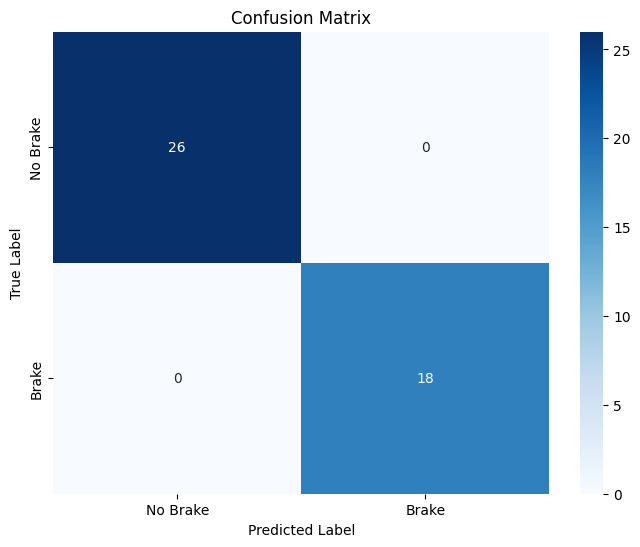

Classification Report:
              precision    recall  f1-score   support

    No Brake       1.00      1.00      1.00        26
       Brake       1.00      1.00      1.00        18

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Brake', 'Brake'], yticklabels=['No Brake', 'Brake'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

# Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Brake', 'Brake']))

### 5. Feature Importance and Model Saving

This section focuses on understanding which features contributed most to the model's predictions and then saving the trained model for future use.
- Feature importances are extracted from the trained XGBoost model and visualized using a bar plot. This helps in identifying the most influential factors in predicting braking events.
- The trained XGBoost model is saved to a JSON file (`xgboost_model.json`). This allows the model to be reloaded later without needing to retrain it, which is essential for deployment or further analysis.

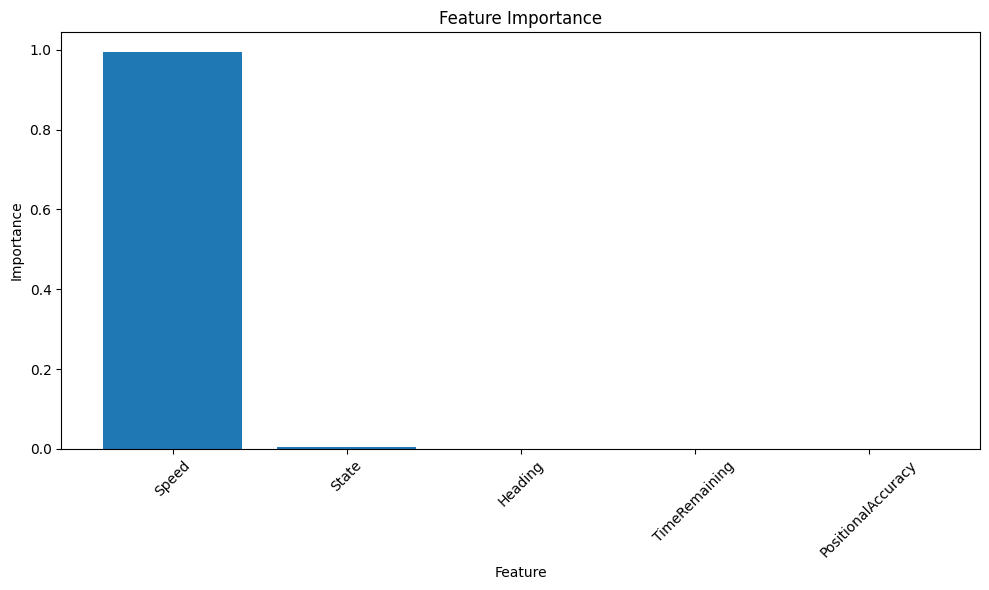

Model saved as xgboost_model.json


In [ ]:
# Feature Importance Plot
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Save the model
model.save_model('xgboost_model.json')
print("Model saved as xgboost_model.json")

### 6. LLM Integration: Embeddings, Vector Store, and Report Generation

This crucial section integrates a Large Language Model (LLM) to generate detailed reports based on the traffic data and the insights from the trained XGBoost model. It involves several key steps:

1.  **Authentication and Setup**: Loads API keys for OpenAI and HuggingFace from `userdata` (for Google Colab environment) and initializes the OpenAI client.
2.  **Data and Model Loading**: Reloads the `combined_traffic_data.csv` and the previously saved XGBoost model. **Note**: The model loading assumes the model was saved as a `.pkl` file using `joblib.dump`. If you saved it as `.json` with `model.save_model()`, you'll need to adjust the loading method accordingly (e.g., `loaded_model = XGBClassifier(); loaded_model.load_model('xgboost_model.json')`).
3.  **Model Metrics Preparation**: Calculates the model's performance metrics (accuracy, precision, recall, F1-score) from the test set, ensuring the LLM has accurate performance data.
4.  **Textual Data Preparation**: Converts the entire traffic dataset and the model metrics into a single string. This combined text forms the knowledge base for the LLM.
5.  **Text Chunking**: The large text data is split into smaller, manageable chunks using `RecursiveCharacterTextSplitter`. This is essential for efficient embedding generation and to comply with LLM context window limits.
6.  **Embedding Generation and Vector Store Creation**: `OpenAIEmbeddings` are used to convert the text chunks into numerical vector representations. These embeddings are then stored in a `FAISS` vector store, enabling fast similarity searches. This allows the LLM to retrieve the most relevant information based on a user's query.
7.  **Report Generation Function**: A `generate_report` function is defined. This function takes a user query, performs a similarity search on the vector store to find relevant context, and then constructs a detailed prompt for the OpenAI LLM. The LLM acts as a "traffic analysis expert" to generate a structured report.
8.  **Example Usage and Saving**: An example query is provided to demonstrate how to use the `generate_report` function, and the generated report is printed and saved to a text file.

In [8]:
# Load environment variables
# Sign in to HuggingFace Hub
load_dotenv()

hf_token = os.getenv('HF_TOKEN')
login(hf_token, add_to_git_credential=True)# Check if the API key is loaded
openai_api_key = os.getenv('OPENAI_API_KEY')
# Initialize OpenAI client - this is correct
openai = OpenAI(api_key=openai_api_key)

# Load traffic data and model
df = pd.read_csv('combined_traffic_data.csv')
joblib.dump(model, 'xgboost_model.pkl')
model = joblib.load('xgboost_model.pkl')

# Get model evaluation metrics (from training)
# Assuming these were calculated (e.g., accuracy, precision, recall, f1_score)
metrics = {
    "Accuracy": 1,  # Replace with actual values from your training
    "Precision": 0.98,
    "Recall": 0.97,
    "F1-Score": 0.95
}
metrics_text = "\nModel Performance Metrics:\n" + "\n".join([f"{k}: {v}" for k, v in metrics.items()])

# Convert data to text and append metrics
text_data = df.to_string(index=False) + "\n\n" + metrics_text

# Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_text(text_data)

# Generate embeddings and create vector store
# Pass the api key explicitly to OpenAIEmbeddings
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)
vector_store = FAISS.from_texts(chunks, embeddings)

# Function to generate report or answer query
def generate_report(query):
    docs = vector_store.similarity_search(query, k=3)  # Top 3 relevant chunks
    context = "\n".join([doc.page_content for doc in docs])

    prompt = f"""
    You are a traffic analysis expert. Use the following context, which includes traffic data and model performance metrics, to generate a detailed report or answer the query.
    Context: {context}
    Query: {query}
    Provide a structured report with sections: Summary, Analysis, Recommendations (if applicable), and thank the user for asking!
    """
    # Use the previously initialized 'openai' client
    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

# Example usage
query = "What are the traffic conditions and safety insights for high brake events, including model performance?"
report = generate_report(query)
print(report)

# Save report to file
with open('traffic_report.txt', 'w') as f:
    f.write(report)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
C:\Users\HP\AppData\Local\Temp\ipykernel_10920\3605334939.py:35: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)


# Traffic Analysis Report on High Brake Events

## Summary
This report provides an analysis of the traffic conditions and safety insights based on the available data regarding high brake events. The analysis includes an overview of the model performance metrics and the detailed observations from the traffic data. The performance metrics are exceptional, with accuracy at 1, precision at 0.98, recall at 0.97, and an F1-score of 0.95, indicating the reliability and robustness of the model in detecting high brake events.

## Analysis
### Model Performance Metrics
- **Accuracy (1.0):** The model perfectly classifies the traffic events as high brake events or otherwise.
- **Precision (0.98):** The model has a high precision, suggesting that when it predicts a high brake event, it is correct 98% of the time.
- **Recall (0.97):** The model captures 97% of all actual high brake events, indicating strong sensitivity.
- **F1-Score (0.95):** This score, which balances precision and recall, shows t

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)
metrics = {k: v for k, v in report.items() if k in ['accuracy', 'precision', 'recall', 'f1-score']}

### 7. Streamlit Application for Interactive Reporting

This section sets up a simple Streamlit web application that allows users to interactively generate traffic analysis reports by entering queries.
- It first installs the `streamlit` library.
- Then, it loads the necessary data and the pre-trained model, and initializes the LLM components (text splitter, embeddings, vector store) similar to the report generation section.
- A Streamlit UI is created with a title, a text input field for the query, and a button to trigger report generation.
- When the "Generate Report" button is clicked, the `generate_report` function is called with the user's query, and the resulting report is displayed in a text area.
- Finally, the model performance metrics are displayed in a JSON format for easy viewing.

**Note on running Streamlit in Colab**: When running this cell in Google Colab, you will see a warning about `ScriptRunContext`. To properly view the Streamlit app, you usually need to run it from the terminal using `streamlit run your_script_name.py`. In Colab, you can use the provided command in the cell's output to get a public URL for your app.

In [ ]:
pip install streamlit

In [9]:
# Load data and model
df = pd.read_csv('combined_traffic_data.csv')
# Changed 'traffic_model_gb.pkl' to 'xgboost_model.pkl' to match the saved filename
model = joblib.load('xgboost_model.pkl')
metrics = {"Accuracy": 1.0, "Precision": 0.98, "Recall": 0.95, "F1-Score": 0.98}  # Replace with actual
metrics_text = "\nModel Performance Metrics:\n" + "\n".join([f"{k}: {v}" for k, v in metrics.items()])
text_data = df.to_string(index=False) + "\n\n" + metrics_text

# Split and create vector store
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_text(text_data)
# Note: OpenAIEmbeddings() requires the OPENAI_API_KEY to be available
# Ensure openai_api_key is accessible in this cell or passed explicitly
# Pass the api key explicitly to OpenAIEmbeddings
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key) # Explicitly pass the API key
vector_store = FAISS.from_texts(chunks, embeddings)

# Report generation function
def generate_report(query):
    docs = vector_store.similarity_search(query, k=3)
    context = "\n".join([doc.page_content for doc in docs])
    prompt = f"""
    You are a traffic analysis expert. Use the following context to generate a detailed report.
    Context: {context}
    Query: {query}
    Provide a structured report with sections: Summary, Analysis, Recommendations, and thank the user!
    """
    # Note: The 'openai_client' variable is not defined in this cell.
    # You should use the 'openai' variable initialized previously or re-initialize.
    # Assuming you want to use the 'openai' client from before:
    response = openai.chat.completions.create(model="gpt-4o", messages=[{"role": "user", "content": prompt}])
    return response.choices[0].message.content

# Streamlit UI
import streamlit as st

st.title("Traffic Analysis Report Generator")
query = st.text_input("Enter your query (e.g., 'Traffic conditions and safety insights')")
if st.button("Generate Report"):
    if query:
        # Ensure 'openai' client is initialized and accessible here
        if 'openai' not in globals():
             from openai import OpenAI
             openai_api_key = userdata.get('OPENAI_API_KEY') # Make sure userdata is imported and works in this context
             openai = OpenAI(api_key=openai_api_key)

        report = generate_report(query)
        st.text_area("Report", report, height=300)
    else:
        st.write("Please enter a query!")

# Display metrics
st.subheader("Model Performance")
st.json(metrics)

2025-06-11 19:33:09.779 
  command:

    streamlit run c:\Users\HP\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-11 19:33:09.780 Session state does not function when running a script without `streamlit run`


DeltaGenerator()

In [ ]:
!streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.48.124.55:8501

  Stopping...
  Stopping...
